In [16]:
import torch
import torch.nn as nn
from AudioDataset import AudioDataset
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [17]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using CUDA device for GPU acceleration.


In [18]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [19]:
class AudioTransformer(nn.Module):
    def __init__(self, n_mels=80, n_classes=12, d_model=128, nhead=4, num_layers=2, dim_feedforward=256):
        super(AudioTransformer, self).__init__()
        self.input_proj = nn.Linear(n_mels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.input_proj(x)
        transformer_out = self.transformer_encoder(x)
        x = transformer_out.mean(dim=1)
        out = self.classifier(x)
        return out

In [20]:
dataset = AudioDataset(
    csv_path="./data/train_balanced.csv",
    audio_dir="./data_raw/train/audio"
)
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

In [21]:
model = AudioTransformer()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
model = model.to(device)

In [10]:
for epoch in range(15):
    model.train()
    running_loss = 0.0

    for i, (images, labels) in enumerate(dataloader):
        inputs, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader):.4f}")

Epoch 1, Loss: 1.2242
Epoch 2, Loss: 0.6239
Epoch 3, Loss: 0.5026
Epoch 4, Loss: 0.4251
Epoch 5, Loss: 0.3807


In [11]:
PATH = f'./transformer_saved/transformer.pth'
torch.save(model.state_dict(), PATH)

In [12]:
dataset = AudioDataset(
    csv_path="./data/test.csv",
    audio_dir="./data_raw/train/audio"
)
test_loader = DataLoader(dataset, batch_size=1, shuffle=True, drop_last=True)

In [13]:
model.eval() 
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]
all_preds = []
all_labels = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for _ in range(12)]
    n_class_samples = [0 for _ in range(12)]

    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()

        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1

acc = 100.0 * n_correct / n_samples
print(f'Accuracy of the network: {acc:.2f}%')

for i in range(12):
    class_acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of class "{classes[i]}": {class_acc:.2f}%')

Accuracy of the network: 78.90%
Accuracy of class "yes": 91.80%
Accuracy of class "no": 74.21%
Accuracy of class "up": 91.18%
Accuracy of class "down": 85.77%
Accuracy of class "left": 78.65%
Accuracy of class "right": 83.40%
Accuracy of class "on": 91.06%
Accuracy of class "off": 81.68%
Accuracy of class "stop": 96.79%
Accuracy of class "go": 80.88%
Accuracy of class "silence": 93.02%
Accuracy of class "unknown": 74.79%


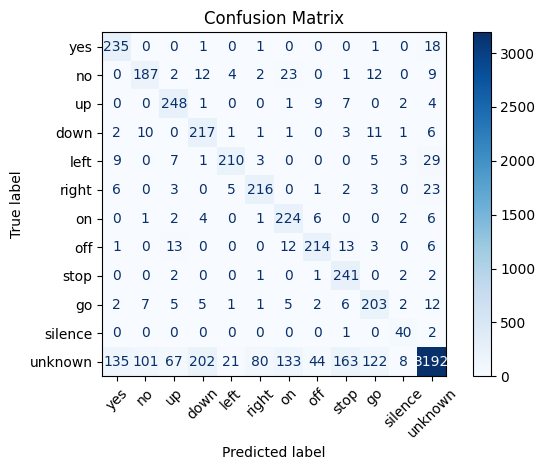

In [15]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()